In [69]:
#Find the best customer challenge
import os
import re
import random
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from math import log
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
import torch
torch.__version__

'1.0.1.post2'

In [4]:
FILE_PATH = "/home/ubuntu/kaggle/custana/testData.txt"


In [5]:
#Reading Data
with open(FILE_PATH, 'r') as f:
    x = f.readlines()

f.close()

In [6]:
list_input = []
i=0
for line in x :
	line = line.strip(",\n")
	data = line.split(",")
	if i > 0:
		dob_split = data[1].split("/")
		if len(dob_split)>1:
			data[1] = dob_split[2]+dob_split[0]+dob_split[1]
		date_pay = data[4].split("/")
		if len(date_pay)>1:
			data[4]= date_pay[2]+date_pay[0]+date_pay[1]
	list_input.append(data)
	i+=1


In [7]:
raw_df = pd.DataFrame(list_input[1:],columns = list_input[0])
raw_df.dob = pd.to_datetime(raw_df.dob, format="%Y%m%d").dt.date
raw_df["pay_month_year"] = pd.to_datetime(raw_df.paymentDate, format="%Y%m%d").dt.to_period("M")
raw_df.paymentDate = pd.to_datetime(raw_df.paymentDate, format="%Y%m%d").dt.date
raw_df.loc[raw_df.paymentAmount=="",["paymentAmount"]] = "0"
#raw_df.reset_index(inplace = True)

raw_df.paymentAmount = pd.to_numeric(raw_df.paymentAmount, downcast='float')
raw_df.rentAmount = pd.to_numeric(raw_df.rentAmount, downcast='float')

In [8]:
#Create new variable
raw_df["pay_diff"] = list(map(lambda x,y:x-y,raw_df["paymentAmount"],raw_df["rentAmount"]))
raw_df["neg_diff"] = raw_df["pay_diff"]<0
#del raw_df["neg_diff"]
#raw_df.head()

In [9]:
raw_df.loc[raw_df["paymentAmount"]<0,["paymentAmount"]] =0

In [10]:
def get_year(dt):
    return dt.year
def get_month(dt):
    return dt.month
def get_day(dt):
    return dt.day
def get_week(dt):
    return dt.isocalendar()[1]

raw_df["pyear"],raw_df["pmonth"],raw_df["pday"],raw_df["pweek"] = raw_df["paymentDate"].apply(get_year),raw_df["paymentDate"].apply(get_month),raw_df["paymentDate"].apply(get_day), raw_df["paymentDate"].apply(get_week)
#raw_df.head()

In [11]:
def calculate_age(born):
    today = datetime.date.today()
    try: 
        birthday = born.replace(year=today.year)
    except ValueError: # raised when birth date is February 29 and the current year is not a leap year
        birthday = born.replace(year=today.year, month=born.month+1, day=1)
    if birthday > today:
        return today.year - born.year - 1
    else:
        return today.year - born.year



In [12]:
min_df = raw_df.groupby(["name"])["paymentDate"].min()
max_df = raw_df.groupby(["name"])["paymentDate"].max()
min_df = pd.DataFrame(min_df)
max_df = pd.DataFrame(max_df)
min_df
min_df["oldest_customer"] = list(map(lambda x: x.year-min(raw_df.paymentDate).year,min_df.paymentDate))
max_df["recent_transaction"] = list(map(lambda x: max(raw_df.paymentDate).year-x.year,max_df.paymentDate))
del min_df["paymentDate"]
del max_df["paymentDate"]
min_df.reset_index(level =0,inplace = True)
max_df.reset_index(level =0,inplace = True)
cust_journey = pd.merge(min_df,max_df,on=["name"],how="inner")


In [13]:
cust_journey["old_cust"]=False
cust_journey["discont_cust"] = False
cust_journey.loc[cust_journey["oldest_customer"]==0,"old_cust"]=True
cust_journey.loc[cust_journey["recent_transaction"]!=0,"discont_cust"]=True
del cust_journey["oldest_customer"]
del cust_journey["recent_transaction"]
cust_journey.head()

name  old_cust  discont_cust
0   Aaron Huston      True         False
1    Abbey Kluth      True         False
2    Abe Prophet      True         False
3    Abel Emmett      True         False
4  Abraham Maggi      True         False

In [14]:
raw_df["age"] = list(map(lambda x:calculate_age(x),raw_df["dob"]))
age_df = pd.pivot_table(raw_df,index=["name"],values=["age"],aggfunc=lambda x: x.unique()[0])
age_df = pd.DataFrame(age_df.to_records())
age_df.loc[(age_df["age"]==119)|(age_df["age"]<18),"age"] = 0

age_df.head()


name  age
0   Aaron Huston    0
1    Abbey Kluth    0
2    Abe Prophet    0
3    Abel Emmett   45
4  Abraham Maggi    0

In [15]:
def replace(group):
    median = group.median()
    #print(median)
    outliers = (group ==119) | (group < 18)
    #print(outliers)
    group[outliers] = group[~outliers].median()    # or "group[~outliers].mean()
    return group

raw_df["c_age"] = raw_df.groupby('houseZip')["age"].transform(replace).astype(int)
age_df_2 = raw_df.groupby(["name"])["c_age"].mean().astype(int)
age_df_2 = pd.DataFrame(age_df_2)
age_df_2.columns = ["c_age"]
del raw_df["c_age"]
age_df_2.reset_index(level=0,inplace=True)

age_df_2.head()

name  c_age
0   Aaron Huston     38
1    Abbey Kluth     46
2    Abe Prophet     42
3    Abel Emmett     45
4  Abraham Maggi     41

In [16]:
multihz_df = pd.pivot_table(raw_df,index=["name"],columns = ["houseZip"],values=["houseID"],aggfunc=lambda x: len(x.unique()))
multihz_df = pd.DataFrame(multihz_df.to_records())
multihz_df.columns = [hdr.replace("('houseID', '", "").replace("')", "") \
                     for hdr in multihz_df.columns]

multihz_df.fillna(0,inplace = True)
multihz_df.head()

name  92101  92102  92103  92104  92105  92106  92107  92108  \
0   Aaron Huston    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    Abbey Kluth    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    Abe Prophet    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    Abel Emmett    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
4  Abraham Maggi    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   92109  ...    92190  92191  92192  92193  92194  92195  92196  92197  \
0    0.0  ...      0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
1    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   92198  92199  
0    0.0    0.0  
1    1.0    0.0  
2    0.0    0.0  
3    0.0    0.0  
4    0.0    0.0  

[5 rows x 82 columns]

In [17]:
raw_df["early_payment"]= list(map(lambda x:x<10,raw_df.pday))
raw_df["late_payment"]= list(map(lambda x:x>10,raw_df.pday))
raw_df.head()
pay_df = raw_df.groupby(["name"])["early_payment","late_payment"].sum().astype(int)
pay_df.reset_index(level =0,inplace=True)
pay_df.head()



name  early_payment  late_payment
0   Aaron Huston             32             0
1    Abbey Kluth             12            20
2    Abe Prophet             32             0
3    Abel Emmett             32             0
4  Abraham Maggi             23             3

In [18]:
capacity_df = raw_df.groupby(["name"])["paymentAmount"].mean()
capacity_df = pd.DataFrame(capacity_df)
capacity_df.columns = ["avg_pay_capacity"]
capacity_df.reset_index(level=0,inplace=True)
capacity_df.head()

name  avg_pay_capacity
0   Aaron Huston       1720.000000
1    Abbey Kluth       1845.968750
2    Abe Prophet       1107.281250
3    Abel Emmett       1802.000000
4  Abraham Maggi       1306.800049

In [19]:
default_df = raw_df.groupby(["name"])["neg_diff"].sum().astype(int)
default_df = pd.DataFrame(default_df)
default_df.loc[default_df["neg_diff"]>0,"defaulter"] = default_df["neg_diff"]>0
default_df.fillna(False,inplace=True)
default_df.reset_index(level=0,inplace = True)

default_df.head()

name  neg_diff  defaulter
0   Aaron Huston         0      False
1    Abbey Kluth         0      False
2    Abe Prophet         1       True
3    Abel Emmett         0      False
4  Abraham Maggi         0      False

In [20]:
#Combining df at name level
dfs = [cust_journey,age_df,age_df_2,multihz_df,pay_df,capacity_df, default_df]

customer_behaviour = reduce(lambda left,right: pd.merge(left,right,on='name'), dfs)
customer_behaviour.head()

name  old_cust  discont_cust  age  c_age  92101  92102  92103  \
0   Aaron Huston      True         False    0     38    0.0    0.0    0.0   
1    Abbey Kluth      True         False    0     46    0.0    0.0    0.0   
2    Abe Prophet      True         False    0     42    0.0    0.0    0.0   
3    Abel Emmett      True         False   45     45    0.0    0.0    0.0   
4  Abraham Maggi      True         False    0     41    0.0    0.0    0.0   

   92104  92105    ...      92195  92196  92197  92198  92199  early_payment  \
0    0.0    0.0    ...        0.0    0.0    0.0    0.0    0.0             32   
1    0.0    0.0    ...        0.0    0.0    0.0    1.0    0.0             12   
2    0.0    0.0    ...        0.0    0.0    0.0    0.0    0.0             32   
3    0.0    0.0    ...        0.0    0.0    0.0    0.0    0.0             32   
4    0.0    0.0    ...        0.0    0.0    0.0    0.0    0.0             23   

   late_payment  avg_pay_capacity  neg_diff  defaulter  
0             0       1720.000000         0      False  
1            20       1845.968750         0      False  
2             0       1107.281250         1       True  
3             0       1802.000000         0      False  
4             3       1306.800049         0      False  

[5 rows x 91 columns]

In [21]:
rent_due_df = raw_df.groupby(["name"])["paymentAmount","rentAmount"].sum()
rent_due_df.reset_index(level=0,inplace = True)
to_modeling = pd.merge(customer_behaviour,rent_due_df,on=["name"])
to_modeling.shape

(1989, 93)

In [22]:
to_modeling["npayments"] = to_modeling["early_payment"]+to_modeling["late_payment"]


In [23]:
to_modeling.to_csv("to_modeling.csv",index=False)

In [24]:
#raw_df = pd.read_csv("raw_df.csv")
#customer_behaviour = pd.read_csv("customer_behaviour")
cols_zip = list(raw_df.houseZip.unique())
cols_zip
cust_df = customer_behaviour.drop(["name"], axis=1)
cust_df.head()

old_cust  discont_cust  age  c_age  92101  92102  92103  92104  92105  \
0      True         False    0     38    0.0    0.0    0.0    0.0    0.0   
1      True         False    0     46    0.0    0.0    0.0    0.0    0.0   
2      True         False    0     42    0.0    0.0    0.0    0.0    0.0   
3      True         False   45     45    0.0    0.0    0.0    0.0    0.0   
4      True         False    0     41    0.0    0.0    0.0    0.0    0.0   

   92106    ...      92195  92196  92197  92198  92199  early_payment  \
0    0.0    ...        0.0    0.0    0.0    0.0    0.0             32   
1    0.0    ...        0.0    0.0    0.0    1.0    0.0             12   
2    0.0    ...        0.0    0.0    0.0    0.0    0.0             32   
3    0.0    ...        0.0    0.0    0.0    0.0    0.0             32   
4    0.0    ...        0.0    0.0    0.0    0.0    0.0             23   

   late_payment  avg_pay_capacity  neg_diff  defaulter  
0             0       1720.000000         0      False  
1            20       1845.968750         0      False  
2             0       1107.281250         1       True  
3             0       1802.000000         0      False  
4             3       1306.800049         0      False  

[5 rows x 90 columns]

In [201]:
#raw_df.to_csv("raw_df.csv",index=False)
customer_behaviour.to_csv("customer_behaviour.csv",index=False)


In [26]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomTreesEmbedding
from sklearn.decomposition import TruncatedSVD

# make a synthetic dataset
X, y = cust_df.drop(["defaulter","c_age"],axis=1),cust_df["defaulter"]
#print(X)
#print(y)
# use RandomTreesEmbedding to transform data
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X)
X_transformed

# Visualize result after dimensionality reduction using truncated SVD
svd = TruncatedSVD(n_components=50)
X_reduced = svd.fit_transform(X_transformed)

#print(svd.explained_variance_ratio_)  

print(svd.explained_variance_ratio_.sum())  

#print(svd.singular_values_) 
X_reduced.shape

0.9949073127652813


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(1989, 50)

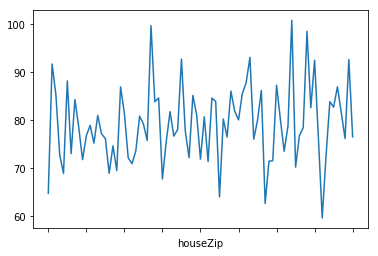

In [27]:
#Analysis of each column
#Age
raw_df.groupby(["houseZip"])["age"].mean().plot()


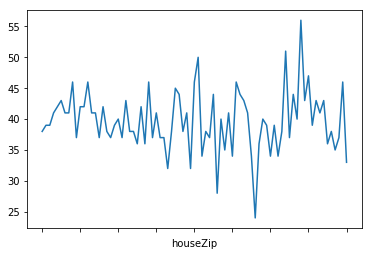

In [28]:
median_age_by_houseZip = raw_df[raw_df["age"]!=119].groupby(["houseZip"])["age"].median().astype(int)
median_age_by_houseZip.plot()


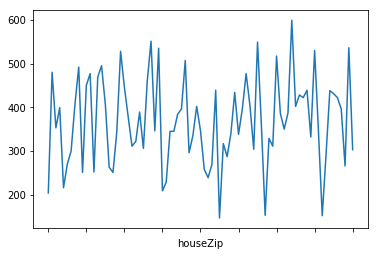

In [196]:
raw_df[raw_df["age"]==119].groupby(["houseZip"])["age"].count().plot()

In [31]:

houseID_profile = pd.pivot_table(raw_df,index=["houseID"],columns = ["houseZip"],values =["name"],aggfunc=lambda x: len(x.unique()))
houseID_profile = pd.DataFrame(houseID_profile.to_records())
houseID_profile.columns = ["houseID"]+list(cols_zip)
houseID_profile.fillna(0,inplace=True)
houseID_profile = houseID_profile.astype(int)
houseID_profile.head()

houseID  92154  92111  92159  92137  92136  92103  92161  92190  92177  \
0        1      0      0      0      0      0      0      0      0      0   
1       10      0      0      0      0      0      0      0      0      0   
2      100      0      0      0      0      0      0      0      0      0   
3     1000      0      0      0      0      0      0      0      0      0   
4     1001      0      0      0      0      0      0      0      0      0   

   ...    92107  92167  92134  92175  92121  92196  92133  92158  92122  92149  
0  ...        0      0      0      0      1      0      0      0      0      0  
1  ...        0      0      0      0      0      0      0      0      0      0  
2  ...        0      0      0      0      0      0      0      0      0      0  
3  ...        0      0      0      0      0      0      0      0      0      0  
4  ...        0      0      0      0      1      0      0      0      0      0  

[5 rows x 82 columns]

In [32]:
# make a synthetic dataset
xH = houseID_profile.drop(["houseID"],axis=1)
#print(X)
#print(y)
# use RandomTreesEmbedding to transform data
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
xH_transformed = hasher.fit_transform(xH)
print(xH_transformed.shape)

# Visualize result after dimensionality reduction using truncated SVD
svd = TruncatedSVD(n_components=30)
xH_reduced = svd.fit_transform(xH_transformed)

#print(svd.explained_variance_ratio_)  

print(svd.explained_variance_ratio_.sum())  

#print(svd.singular_values_) 
print(xH_reduced.shape)

      

(2475, 40)
0.9999999999999929
(2475, 30)


In [33]:
#Data Preparation for DL method
raw_df.columns
houseID_embeddings = pd.DataFrame(xH_reduced)

houseID_embeddings["houseID"] = houseID_profile.houseID
houseID_embeddings["houseID"] = houseID_embeddings["houseID"].astype(str)
houseID_embeddings["enc_houseID"] = list(range(len(houseID_embeddings)))
houseID_embeddings.head()
#houseID_embeddings


0         1         2         3         4         5         6  \
0  3.16164 -0.004024  0.001717 -0.002743 -0.003542  0.001951  0.000132   
1  3.16164 -0.004024  0.001717 -0.002743 -0.003542  0.001951  0.000132   
2  3.16164 -0.004024  0.001717 -0.002743 -0.003542  0.001951  0.000132   
3  3.16164 -0.004024  0.001717 -0.002743 -0.003542  0.001951  0.000132   
4  3.16164 -0.004024  0.001717 -0.002743 -0.003542  0.001951  0.000132   

         7         8        9     ...            22        23        24  \
0 -0.00289 -0.002177 -0.01892     ...       0.00411  0.026357 -0.044025   
1 -0.00289 -0.002177 -0.01892     ...       0.00411  0.026357 -0.044025   
2 -0.00289 -0.002177 -0.01892     ...       0.00411  0.026357 -0.044025   
3 -0.00289 -0.002177 -0.01892     ...       0.00411  0.026357 -0.044025   
4 -0.00289 -0.002177 -0.01892     ...       0.00411  0.026357 -0.044025   

             25            26            27            28            29  \
0 -8.953645e-15  1.385000e-15  1.356944e-15  1.997290e-15 -8.315612e-16   
1 -1.507830e-14 -4.296800e-15  7.403089e-16  3.432397e-16 -2.510089e-15   
2  1.804871e-14  5.983165e-15 -6.921783e-16  4.334225e-15 -1.828955e-15   
3  1.491145e-14 -2.515304e-15 -1.110557e-15  6.412353e-15 -2.052079e-15   
4 -1.574351e-14 -8.381515e-15  5.723438e-15  2.853469e-15  2.601327e-16   

   houseID  enc_houseID  
0        1            0  
1       10            1  
2      100            2  
3     1000            3  
4     1001            4  

[5 rows x 32 columns]

In [34]:
customer_embedding = pd.DataFrame(X_reduced)
customer_embedding["name"] = customer_behaviour.name
customer_embedding.head()
customer_embedding["enc_name"] = list(range(len(customer_embedding)))
customer_embedding.head()

0         1         2         3         4         5         6  \
0  3.160833 -0.060103 -0.011244 -0.002724  0.002144  0.003315  0.008742   
1  3.160833 -0.060103 -0.011244 -0.002724  0.002144  0.003315  0.008742   
2  2.848331 -0.105137 -0.239180  0.437791 -0.058594  0.863309 -0.241551   
3  3.160833 -0.060103 -0.011244 -0.002724  0.002144  0.003315  0.008742   
4  3.160833 -0.060103 -0.011244 -0.002724  0.002144  0.003315  0.008742   

          7         8         9    ...           42        43        44  \
0  0.005359 -0.003968  0.049837    ...     0.000302  0.000760  0.001034   
1  0.005359 -0.003968  0.049837    ...     0.000302  0.000760  0.001034   
2 -0.009149 -0.054594 -0.107412    ...     0.000798  0.000841  0.000749   
3  0.005359 -0.003968  0.049837    ...     0.000302  0.000760  0.001034   
4  0.005359 -0.003968  0.049837    ...     0.000302  0.000760  0.001034   

         45            46            47            48            49  \
0 -0.000858 -1.922423e-16  3.842637e-17 -4.877692e-17 -1.778736e-16   
1 -0.000858 -6.499391e-16 -1.200940e-16 -4.555424e-16 -9.740207e-17   
2 -0.000154 -1.118377e-16 -3.221958e-16  5.701952e-16 -2.162696e-16   
3 -0.000858 -4.659413e-18  3.738590e-16 -2.281376e-16 -1.010464e-16   
4 -0.000858 -2.990883e-16 -1.558052e-17 -2.343896e-16 -2.468403e-17   

            name  enc_name  
0   Aaron Huston         0  
1    Abbey Kluth         1  
2    Abe Prophet         2  
3    Abel Emmett         3  
4  Abraham Maggi         4  

[5 rows x 52 columns]

In [35]:
data_m = raw_df.groupby(["name"])["name"].count()
data_m = pd.DataFrame(data_m)
data_m.columns = ["count"]
data_m.reset_index(level=0,inplace=True)
customer_names = list(data_m[data_m["count"]!=1]["name"])

In [116]:

df_h = houseID_embeddings[["houseID","enc_houseID"]]
X_input = pd.merge(raw_df,df_h,on=["houseID"],how="left")

df_u = customer_embedding[["name","enc_name"]]
X_input = pd.merge(X_input,df_u,on=["name"],how="left")

X_input.sort_values(["name","pay_month_year"])
#X_input["target"] = [[1,0]] * len(X_input)



name         dob houseID houseZip paymentDate  paymentAmount  \
39556  Aaron Huston  1900-01-01       1    92194  2010-02-01         1720.0   
41968  Aaron Huston  1900-01-01       1    92194  2010-03-01         1720.0   
28952  Aaron Huston  1900-01-01       1    92194  2010-04-01         1720.0   
26225  Aaron Huston  1900-01-01       1    92194  2010-05-01         1720.0   
24949  Aaron Huston  1900-01-01       1    92194  2010-06-01         1720.0   
5685   Aaron Huston  1900-01-01       1    92194  2010-07-01         1720.0   
16197  Aaron Huston  1900-01-01       1    92194  2010-08-01         1720.0   
15994  Aaron Huston  1900-01-01       1    92194  2010-09-01         1720.0   
49653  Aaron Huston  1900-01-01       1    92194  2010-10-01         1720.0   
40044  Aaron Huston  1900-01-01       1    92194  2010-11-01         1720.0   
51074  Aaron Huston  1900-01-01       1    92194  2010-12-01         1720.0   
54259  Aaron Huston  1900-01-01       1    92194  2011-01-01         1720.0   
51184  Aaron Huston  1900-01-01       1    92194  2011-02-01         1720.0   
9384   Aaron Huston  1900-01-01       1    92194  2011-03-01         1720.0   
19306  Aaron Huston  1900-01-01       1    92194  2011-04-01         1720.0   
22409  Aaron Huston  1900-01-01       1    92194  2011-05-01         1720.0   
29240  Aaron Huston  1900-01-01       1    92194  2011-06-01         1720.0   
48226  Aaron Huston  1900-01-01       1    92194  2011-07-01         1720.0   
17575  Aaron Huston  1900-01-01       1    92194  2011-08-01         1720.0   
54969  Aaron Huston  1900-01-01       1    92194  2011-09-01         1720.0   
24403  Aaron Huston  1900-01-01       1    92194  2011-10-01         1720.0   
35522  Aaron Huston  1900-01-01       1    92194  2011-11-01         1720.0   
11783  Aaron Huston  1900-01-01       1    92194  2011-12-01         1720.0   
47267  Aaron Huston  1900-01-01       1    92194  2012-01-01         1720.0   
43537  Aaron Huston  1900-01-01       1    92194  2012-02-01         1720.0   
13609  Aaron Huston  1900-01-01       1    92194  2012-03-01         1720.0   
5664   Aaron Huston  1900-01-01       1    92194  2012-04-01         1720.0   
39201  Aaron Huston  1900-01-01       1    92194  2012-05-01         1720.0   
20623  Aaron Huston  1900-01-01       1    92194  2012-06-01         1720.0   
15672  Aaron Huston  1900-01-01       1    92194  2012-07-01         1720.0   
...             ...         ...     ...      ...         ...            ...   
26451  Zona Thorton  1900-01-01    2475    92124  2010-04-01         1661.0   
26370  Zona Thorton  1900-01-01    2475    92124  2010-05-01         1661.0   
13214  Zona Thorton  1900-01-01    2475    92124  2010-06-03         1661.0   
15372  Zona Thorton  1900-01-01    2475    92124  2010-07-01         1661.0   
49953  Zona Thorton  1900-01-01    2475    92124  2010-08-01         1661.0   
31001  Zona Thorton  1900-01-01    2475    92124  2010-09-01         1661.0   
58727  Zona Thorton  1900-01-01    2475    92124  2010-10-01         1661.0   
11356  Zona Thorton  1900-01-01    2475    92124  2010-11-01         1661.0   
50223  Zona Thorton  1900-01-01    2475    92124  2010-12-01         1661.0   
49919  Zona Thorton  1900-01-01    2475    92124  2011-01-01         1661.0   
16920  Zona Thorton  1900-01-01    2475    92124  2011-02-02         1661.0   
39545  Zona Thorton  1900-01-01    2475    92124  2011-03-02         1661.0   
3865   Zona Thorton  1900-01-01    2475    92124  2011-04-01         1661.0   
10049  Zona Thorton  1900-01-01    2475    92124  2011-05-01         1661.0   
19320  Zona Thorton  1900-01-01    2475    92124  2011-06-01         1661.0   
4566   Zona Thorton  1900-01-01    2475    92124  2011-07-01         1661.0   
46836  Zona Thorton  1900-01-01    2475    92124  2011-08-01         1661.0   
52538  Zona Thorton  1900-01-01    2475    92124  2011-09-01         1661.0   
5175   Zona Thorton  1900-01-01    2475    92124  2011-10-01     

In [118]:
cols = ["paymentAmount" ,"rentAmount","neg_diff","pyear","pmonth","pday","pweek","enc_houseID","enc_name"]

X_input["neg_diff"] = X_input["neg_diff"].astype(int)
customers = list(customer_names)
list_features =[]
list_y = []
for i in customers:
    list_features.append(X_input[X_input["name"]==i][cols].values)
    list_y.append(X_input[X_input["name"]==i]["neg_diff"].values)
    




In [133]:
list_yn = []
#[Good,Bad]
for i in range(len(list_y)):
    a = list_y[i]
    b = np.zeros((len(a), 2))
    b[np.arange((len(a))), a] = 1
    list_yn.append(b)
    

In [137]:
import copy
list_features_valid = copy.deepcopy(list_features)
list_y_valid = copy.deepcopy(list_y)

In [138]:

from torch.nn import functional as F 
from torch.utils.data import Dataset,DataLoader
import os
# os.chdir('/home/ubuntu/kaggle/quora/code')
# standard imports
import time
import random
import os
from IPython.display import display
import numpy as np
import pandas as pd

# pytorch imports
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
# imports for preprocessing the questions
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, precision_recall_curve

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# progress bars
from tqdm import tqdm
tqdm.pandas()

import random
class custDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx):
        seed = random.randint(1,len(self.x[idx])-1)
        #pr#int(seed)
        return (self.x[idx][:seed], self.y[idx][1:seed+1])
    def __len__(self): return len(self.x)


In [147]:
test_ds = custDataset(list_features, list_yn)

In [149]:
#test_ds[0][0][:3]
#test_ds[0][0].shape

array([1., 0.])

In [65]:
#x,y=next(iter())#

In [150]:
batch_size = 32
pad_collate = None
embedding_size = 9

In [151]:
trn_ds = custDataset(list_features, list_yn)
#train_loader = DataLoader(trn_ds, batch_size=batch_size)



In [152]:
def pad_collate(samples, pad_idx=0., pad_first=True):
    "Function that collect samples and adds padding."
    # samples = to_data(samples)
    max_len = max([len(s[0]) for s in samples])
    res = torch.zeros(max_len, len(samples),embedding_size).long() + pad_idx
    for i,s in enumerate(samples):
        if pad_first: res[-len(s[0]):,i] = torch.LongTensor(s[0])
        else:         res[:len(s[0]):,i] = torch.LongTensor(s[0])
    return res, torch.tensor([s[1][-1] for s in samples],dtype=torch.long) # x,y 


In [153]:
train_loader = DataLoader(trn_ds, batch_size=batch_size, collate_fn=pad_collate)


In [157]:

user_max_features = X_reduced.shape[0]
user_embed_size = X_reduced.shape[1]

house_max_features = xH_reduced.shape[0]
house_embed_size = xH_reduced.shape[1]

In [158]:

max_features = X_reduced.shape[0]
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        #        
        hidden_size = 64
        changed_embedding_size = embedding_size-2
         #       
        self.user_embedding = nn.Embedding(user_max_features, user_embed_size)
        self.user_embedding.weight = nn.Parameter(torch.tensor(X_reduced, dtype=torch.float32))
        self.user_embedding.weight.requires_grad = True
        
        self.house_embedding = nn.Embedding(house_max_features, house_embed_size)
        self.house_embedding.weight = nn.Parameter(torch.tensor(xH_reduced, dtype=torch.float32))
        self.house_embedding.weight.requires_grad = True
        
        self.user_linear = nn.Linear(user_embed_size, hidden_size)
        self.house_linear = nn.Linear(house_embed_size, hidden_size)

        #self.user_lstm = nn.LSTM(user_embed_size, hidden_size, batch_first=True)
        
        
        self.lstm1 = nn.LSTM(changed_embedding_size, hidden_size, bidirectional=True, batch_first=True)
        #self.lstm2 = nn.LSTM(hidden_size*4, hidden_size, bidirectional=True, batch_first=True)
        #self.lstm3 = nn.LSTM(embedding_size, hidden_size, bidirectional=True, batch_first=True)
        #self.lstm4 = nn.LSTM(embedding_size, hidden_size, bidirectional=True, batch_first=True)


        self.gru = nn.GRU(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)
        #
        # self.lstm_attention = Attention(hidden_size * 2)
        # self.gru_attention = Attention(hidden_size * 2)
        # #
        self.linear = nn.Linear(hidden_size*6, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(hidden_size, 2)
    #
    def forward(self, x):
        x1 = x[:,:,:-2]
        x1 = x1.permute(1,0,2).float()
        x2 = torch.max(x[:,:,-1],dim = 0)[0] #User Encoding
        x3 = torch.max(x[:,:,-2],dim = 0)[0] #House Encoding
        
        #x.dtype=torch.long
        h_user_embedding = self.user_embedding(x2)
        #h_user_embedding = torch.unsqueeze(h_user_embedding, 0)
        h_house_embedding = self.house_embedding(x2)
        #h_house_embedding = torch.unsqueeze(h_house_embedding, 0)
        
        u_dense = self.relu(self.user_linear(h_user_embedding))
        h_dense = self.relu(self.house_linear(h_house_embedding))
        
        
        #
        h_lstm1, _ = self.lstm1(x1)
        #max_pool1, _ = torch.max(h_lstm1, 1)
        #conc1 = torch.cat((u_dense,h_dense,max_pool1), 1)
        h_gru, _ = self.gru(h_lstm1)
        #
        # h_lstm_atten = self.lstm_attention(h_lstm)
        # h_gru_atten = self.gru_attention(h_gru)
        #
        # global average pooling
        avg_pool = torch.mean(h_gru, 1)
        # global max pooling
        max_pool, _ = torch.max(h_gru, 1)
        #
        conc = torch.cat((u_dense,h_dense,avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        #
        return out
    
    

#---------------
model= NeuralNet()
model.cuda()

NeuralNet(
  (user_embedding): Embedding(1989, 50)
  (house_embedding): Embedding(2475, 30)
  (user_linear): Linear(in_features=50, out_features=64, bias=True)
  (house_linear): Linear(in_features=30, out_features=64, bias=True)
  (lstm1): LSTM(7, 64, batch_first=True, bidirectional=True)
  (gru): GRU(128, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=384, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

In [78]:
#model = torch.load("model1.pth")
#del model

In [159]:
#loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())


In [191]:
n_epochs=500
for epoch in range(n_epochs):
    # set train mode of the model. This enables operations which are only applied during training like dropout
    start_time = time.time()
    model.train()
    avg_loss = 0. 
    print(f'{epoch+1}/{n_epochs}')
    for x_batch, y_batch in tqdm(train_loader, disable=True):
        x_batch,y_batch=x_batch.cuda(),torch.unsqueeze(y_batch,dim=1).float().cuda()
        # torch.unsqueeze(y_batch,dim=1).float().cuda()
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x_batch)
        # Compute and print loss.
        loss = loss_fn(y_pred, y_batch)
        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the Tensors it will update (which are the learnable weights
        # of the model)
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    print('loss:{}'.format(avg_loss))

1/500
loss:0.03036489103349947
2/500
loss:0.03663371398203796
3/500
loss:0.03736554607448558
4/500
loss:0.03583858491131855
5/500
loss:0.03819304689644806
6/500
loss:0.034261247969322624
7/500
loss:0.04020461782572728
8/500
loss:0.035141919709501736
9/500
loss:0.029919659133039178
10/500
loss:0.03351853954635801
11/500
loss:0.029277254526893934
12/500
loss:0.03247837143980208
13/500
loss:0.030598880212393497
14/500
loss:0.024321933817719264
15/500
loss:0.033088462277045164
16/500
loss:0.025566103057034557
17/500
loss:0.02743992892154042
18/500
loss:0.03030563145875931
19/500
loss:0.028195546429243778
20/500
loss:0.034053809550260355
21/500
loss:0.02606796640752545
22/500
loss:0.029686894808565414
23/500
loss:0.02656720094983616
24/500
loss:0.026710461126640443
25/500
loss:0.019250961613931472
26/500
loss:0.022690540449994225
27/500
loss:0.023653451796440832
28/500
loss:0.022579480090268687
29/500
loss:0.02348327554101426
30/500
loss:0.022019607698424683
31/500
loss:0.02433514225506975


loss:0.014738696543058576
249/500
loss:0.019262919426520024
250/500
loss:0.01625453302029846
251/500
loss:0.023303328379810292
252/500
loss:0.020306207268819692
253/500
loss:0.016253217540408163
254/500
loss:0.02332531230325502
255/500
loss:0.015228047668085392
256/500
loss:0.01931060947763106
257/500
loss:0.015742391525926058
258/500
loss:0.013730670761370058
259/500
loss:0.013766871372882314
260/500
loss:0.01882686823251612
261/500
loss:0.022788881395979028
262/500
loss:0.021325815910351535
263/500
loss:0.015791564152403872
264/500
loss:0.019286823909844254
265/500
loss:0.025880826561279383
266/500
loss:0.01676292519511164
267/500
loss:0.01775392984329242
268/500
loss:0.014262329321295952
269/500
loss:0.016791218583039738
270/500
loss:0.02138475458911759
271/500
loss:0.01624646004843417
272/500
loss:0.018277187427634824
273/500
loss:0.021852513799785808
274/500
loss:0.018770868183321087
275/500
loss:0.016737447196177403
276/500
loss:0.015755252928072644
277/500
loss:0.024370154464415

loss:0.016720487274347582
493/500
loss:0.01472180674324092
494/500
loss:0.018304940926100247
495/500
loss:0.01727737092445633
496/500
loss:0.020271313514263797
497/500
loss:0.016266949309972977
498/500
loss:0.021278180118667563
499/500
loss:0.021828540700939363
500/500
loss:0.022853183778337435


In [161]:
print(avg_loss)

0.03622712663585139


In [202]:
torch.save(model,"model_3.pth")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type NeuralNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [203]:
torch.save(model.state_dict(),"model_3_state.pth")

In [162]:
class custtestDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return (self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)


In [169]:
batch_size = 1
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


0.8807970779778823

In [164]:
test_ds = custtestDataset(list_features_valid, list_y_valid)
test_loader = DataLoader(test_ds, batch_size,  num_workers=1, collate_fn=pad_collate,shuffle=False)


In [186]:
#actual=[]
pred=[]
for i, (x_batch,y_batch) in enumerate(test_loader):
        #print(i)
        x_batch=x_batch.cuda()
        y_pred = model(x_batch).detach()
        #print(y_pred)
        y_pred=torch.nn.functional.softmax(y_pred[0],dim=0).cpu().numpy()[0]
        #print("------------")
        #print(y_pred)
        pred.append(y_pred)
        #
        #test_preds_fold[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]
        #

tensor([[0.9778, 0.0010]], device='cuda:0')
------------
0.72646683
tensor([[9.3677e-01, 6.7329e-04]], device='cuda:0')
------------
0.7183097
tensor([[1.0345e+00, 8.7659e-04]], device='cuda:0')
------------
0.7376122
tensor([[1.0104e+00, 7.6974e-04]], device='cuda:0')
------------
0.7329442
tensor([[1.0382e+00, 8.5760e-04]], device='cuda:0')
------------
0.73833144
tensor([[1.0373e+00, 8.7564e-04]], device='cuda:0')
------------
0.7381618
tensor([[9.2478e-01, 7.2652e-04]], device='cuda:0')
------------
0.7158676
tensor([[9.6818e-01, 6.0163e-04]], device='cuda:0')
------------
0.72463685
tensor([[1.0184e+00, 8.5983e-04]], device='cuda:0')
------------
0.7344969
tensor([[1.0104e+00, 9.2080e-04]], device='cuda:0')
------------
0.73291975
tensor([[9.8672e-01, 8.2556e-04]], device='cuda:0')
------------
0.72827685
tensor([[1.0049e+00, 8.3165e-04]], device='cuda:0')
------------
0.73186576
tensor([[1.0458e+00, 9.1596e-04]], device='cuda:0')
------------
0.7397921
tensor([[9.8542e-01, 7.5713

tensor([[9.9249e-01, 9.4412e-04]], device='cuda:0')
------------
0.72939396
tensor([[9.8060e-01, 6.6356e-04]], device='cuda:0')
------------
0.72709537
tensor([[9.5020e-01, 7.5942e-04]], device='cuda:0')
------------
0.7210031
tensor([[9.2184e-01, 8.4248e-04]], device='cuda:0')
------------
0.7152463
tensor([[9.4954e-01, 7.2279e-04]], device='cuda:0')
------------
0.7208773
tensor([[9.9214e-01, 9.3089e-04]], device='cuda:0')
------------
0.72932684
tensor([[9.7754e-01, 7.0580e-04]], device='cuda:0')
------------
0.72647965
tensor([[1.0174e+00, 7.8223e-04]], device='cuda:0')
------------
0.7343077
tensor([[9.5419e-01, 6.9641e-04]], device='cuda:0')
------------
0.7218171
tensor([[9.8669e-01, 7.0587e-04]], device='cuda:0')
------------
0.7282938
tensor([[1.0096e+00, 7.8007e-04]], device='cuda:0')
------------
0.73279667
tensor([[9.2367e-01, 7.4493e-04]], device='cuda:0')
------------
0.71563786
tensor([[1.0292e+00, 8.4050e-04]], device='cuda:0')
------------
0.7365957
tensor([[1.0200e+00

------------
0.7335372
tensor([[0.9193, 0.0010]], device='cuda:0')
------------
0.7147042
tensor([[9.3084e-01, 8.6490e-04]], device='cuda:0')
------------
0.71706975
tensor([[1.0060e+00, 8.5199e-04]], device='cuda:0')
------------
0.7320744
tensor([[9.8290e-01, 7.6767e-04]], device='cuda:0')
------------
0.7275309
tensor([[9.5411e-01, 9.0546e-04]], device='cuda:0')
------------
0.7217596
tensor([[9.8575e-01, 7.4889e-04]], device='cuda:0')
------------
0.7281001
tensor([[9.6079e-01, 7.1401e-04]], device='cuda:0')
------------
0.72313756
tensor([[1.0421e+00, 9.0098e-04]], device='cuda:0')
------------
0.73909
tensor([[9.1741e-01, 5.5449e-04]], device='cuda:0')
------------
0.7144019
tensor([[1.0444e+00, 8.6853e-04]], device='cuda:0')
------------
0.73953116
tensor([[1.0194e+00, 7.6603e-04]], device='cuda:0')
------------
0.7347052
tensor([[1.0051e+00, 8.8657e-04]], device='cuda:0')
------------
0.7318873
tensor([[1.0183e+00, 8.5641e-04]], device='cuda:0')
------------
0.7344687
tensor([[

tensor([[9.4722e-01, 7.9844e-04]], device='cuda:0')
------------
0.7203943
tensor([[9.3098e-01, 7.4335e-04]], device='cuda:0')
------------
0.7171243
tensor([[1.0108e+00, 6.8159e-04]], device='cuda:0')
------------
0.7330365
tensor([[1.0197e+00, 7.8913e-04]], device='cuda:0')
------------
0.73475343
tensor([[9.8797e-01, 8.1793e-04]], device='cuda:0')
------------
0.7285259
tensor([[9.8527e-01, 9.7164e-04]], device='cuda:0')
------------
0.72796065
tensor([[1.0062e+00, 7.4561e-04]], device='cuda:0')
------------
0.7321316
tensor([[9.5519e-01, 7.4599e-04]], device='cuda:0')
------------
0.72200876
tensor([[9.8011e-01, 7.7373e-04]], device='cuda:0')
------------
0.7269757
tensor([[8.9422e-01, 8.6128e-04]], device='cuda:0')
------------
0.709583
tensor([[0.9952, 0.0010]], device='cuda:0')
------------
0.7299148
tensor([[9.1673e-01, 8.0301e-04]], device='cuda:0')
------------
0.71421057
tensor([[1.0418e+00, 8.8665e-04]], device='cuda:0')
------------
0.73902553
tensor([[1.0140e+00, 9.0735e-

tensor([[9.8509e-01, 9.2317e-04]], device='cuda:0')
------------
0.72793347
tensor([[9.4575e-01, 7.6037e-04]], device='cuda:0')
------------
0.720106
tensor([[1.0283e+00, 9.0912e-04]], device='cuda:0')
------------
0.7364033
tensor([[9.9497e-01, 8.2251e-04]], device='cuda:0')
------------
0.7299064
tensor([[0.9506, 0.0010]], device='cuda:0')
------------
0.72104806
tensor([[9.8594e-01, 5.6861e-04]], device='cuda:0')
------------
0.7281718
tensor([[9.8758e-01, 7.9102e-04]], device='cuda:0')
------------
0.7284533
tensor([[1.0155e+00, 9.2240e-04]], device='cuda:0')
------------
0.73392016
tensor([[9.1121e-01, 6.8365e-04]], device='cuda:0')
------------
0.71310747
tensor([[1.0066e+00, 8.3341e-04]], device='cuda:0')
------------
0.73219174
tensor([[9.8287e-01, 6.6377e-04]], device='cuda:0')
------------
0.7275452
tensor([[9.2232e-01, 7.8037e-04]], device='cuda:0')
------------
0.7153558
tensor([[9.5522e-01, 8.8695e-04]], device='cuda:0')
------------
0.7219858
tensor([[9.9140e-01, 5.8416e-

tensor([[9.6270e-01, 8.1424e-04]], device='cuda:0')
------------
0.72349936
tensor([[1.0475e+00, 8.5575e-04]], device='cuda:0')
------------
0.7401284
tensor([[9.5064e-01, 7.5710e-04]], device='cuda:0')
------------
0.72109205
tensor([[9.6917e-01, 6.6569e-04]], device='cuda:0')
------------
0.724821
tensor([[0.9819, 0.0010]], device='cuda:0')
------------
0.72728753
tensor([[9.3765e-01, 5.8391e-04]], device='cuda:0')
------------
0.71850723
tensor([[9.4545e-01, 7.1821e-04]], device='cuda:0')
------------
0.72005486
tensor([[9.5819e-01, 7.7285e-04]], device='cuda:0')
------------
0.7226038
tensor([[9.5846e-01, 8.5517e-04]], device='cuda:0')
------------
0.7226429
tensor([[9.8904e-01, 7.7885e-04]], device='cuda:0')
------------
0.72874415
tensor([[9.3170e-01, 5.6492e-04]], device='cuda:0')
------------
0.71730524
tensor([[9.6099e-01, 5.2377e-04]], device='cuda:0')
------------
0.72321475
tensor([[9.5021e-01, 6.8206e-04]], device='cuda:0')
------------
0.7210195
tensor([[1.0141e+00, 7.916

------------
0.7337051
tensor([[9.8464e-01, 7.0653e-04]], device='cuda:0')
------------
0.7278883
tensor([[9.6112e-01, 8.7150e-04]], device='cuda:0')
------------
0.7231722
tensor([[1.0473e+00, 9.1847e-04]], device='cuda:0')
------------
0.7400701
tensor([[9.9063e-01, 8.4438e-04]], device='cuda:0')
------------
0.7290449
tensor([[1.0071e+00, 7.9699e-04]], device='cuda:0')
------------
0.7322977
tensor([[9.7344e-01, 7.7296e-04]], device='cuda:0')
------------
0.7256511
tensor([[9.2004e-01, 8.7791e-04]], device='cuda:0')
------------
0.7148717
tensor([[1.0359e+00, 8.9053e-04]], device='cuda:0')
------------
0.7378863
tensor([[1.0056, 0.0010]], device='cuda:0')
------------
0.73196
tensor([[1.0420e+00, 8.6740e-04]], device='cuda:0')
------------
0.73906237
tensor([[1.0035e+00, 7.5492e-04]], device='cuda:0')
------------
0.7316017
tensor([[9.7781e-01, 7.7253e-04]], device='cuda:0')
------------
0.7265198
tensor([[1.0068e+00, 9.7896e-04]], device='cuda:0')
------------
0.73220795
tensor([[1

tensor([[0.8621, 0.0011]], device='cuda:0')
------------
0.70285344
tensor([[1.0318e+00, 8.6119e-04]], device='cuda:0')
------------
0.7370948
tensor([[1.0415e+00, 8.6405e-04]], device='cuda:0')
------------
0.7389667
tensor([[1.0175e+00, 8.7704e-04]], device='cuda:0')
------------
0.734323
tensor([[9.5761e-01, 9.1731e-04]], device='cuda:0')
------------
0.7224589
tensor([[9.2879e-01, 7.7478e-04]], device='cuda:0')
------------
0.7166723
tensor([[9.4948e-01, 7.9253e-04]], device='cuda:0')
------------
0.7208518
tensor([[9.0343e-01, 6.8620e-04]], device='cuda:0')
------------
0.7115123
tensor([[1.0178e+00, 7.8712e-04]], device='cuda:0')
------------
0.73439354
tensor([[9.5625e-01, 8.3100e-04]], device='cuda:0')
------------
0.72220415
tensor([[9.9323e-01, 9.8407e-04]], device='cuda:0')
------------
0.7295317
tensor([[0.9535, 0.0010]], device='cuda:0')
------------
0.721621
tensor([[0.9526, 0.0010]], device='cuda:0')
------------
0.7214288
tensor([[9.4844e-01, 8.9521e-04]], device='cuda:

tensor([[9.5969e-01, 7.3522e-04]], device='cuda:0')
------------
0.7229128
tensor([[9.8446e-01, 9.0208e-04]], device='cuda:0')
------------
0.72781295
tensor([[9.8219e-01, 9.3020e-04]], device='cuda:0')
------------
0.72735715
tensor([[9.8499e-01, 9.3474e-04]], device='cuda:0')
------------
0.7279122
tensor([[1.0203e+00, 9.0640e-04]], device='cuda:0')
------------
0.7348571
tensor([[9.4776e-01, 7.5412e-04]], device='cuda:0')
------------
0.72051245
tensor([[9.2228e-01, 8.9666e-04]], device='cuda:0')
------------
0.7153245
tensor([[9.5317e-01, 8.8488e-04]], device='cuda:0')
------------
0.72157514
tensor([[1.0134e+00, 8.5428e-04]], device='cuda:0')
------------
0.7335196
tensor([[9.8913e-01, 9.2268e-04]], device='cuda:0')
------------
0.7287344
tensor([[9.3432e-01, 6.0890e-04]], device='cuda:0')
------------
0.7178284
tensor([[9.8253e-01, 7.5918e-04]], device='cuda:0')
------------
0.72745955
tensor([[9.5353e-01, 7.5668e-04]], device='cuda:0')
------------
0.72167325
tensor([[9.8477e-01

tensor([[1.0023e+00, 8.7859e-04]], device='cuda:0')
------------
0.7313319
tensor([[9.4161e-01, 8.7310e-04]], device='cuda:0')
------------
0.719249
tensor([[1.0096e+00, 8.8840e-04]], device='cuda:0')
------------
0.7327679
tensor([[1.0303e+00, 8.9250e-04]], device='cuda:0')
------------
0.73680437
tensor([[8.9634e-01, 8.7831e-04]], device='cuda:0')
------------
0.71001583
tensor([[1.0435e+00, 8.9157e-04]], device='cuda:0')
------------
0.7393464
tensor([[9.7520e-01, 9.5663e-04]], device='cuda:0')
------------
0.7259647
tensor([[8.6681e-01, 6.6591e-04]], device='cuda:0')
------------
0.70394224
tensor([[0.9545, 0.0010]], device='cuda:0')
------------
0.72181547
tensor([[9.4208e-01, 6.9984e-04]], device='cuda:0')
------------
0.7193782
tensor([[9.6455e-01, 8.4512e-04]], device='cuda:0')
------------
0.7238638
tensor([[9.7431e-01, 9.5539e-04]], device='cuda:0')
------------
0.7257877
tensor([[1.0381e+00, 8.7231e-04]], device='cuda:0')
------------
0.73830914
tensor([[9.8240e-01, 9.1018e-

tensor([[9.9366e-01, 8.5406e-04]], device='cuda:0')
------------
0.7296409
tensor([[9.8994e-01, 7.8260e-04]], device='cuda:0')
------------
0.7289212
tensor([[1.0513e+00, 8.6750e-04]], device='cuda:0')
------------
0.74085844
tensor([[8.7648e-01, 5.5474e-04]], device='cuda:0')
------------
0.7059764
tensor([[9.8417e-01, 7.0703e-04]], device='cuda:0')
------------
0.7277954
tensor([[9.4989e-01, 7.8842e-04]], device='cuda:0')
------------
0.7209343
tensor([[9.5915e-01, 5.7118e-04]], device='cuda:0')
------------
0.72283727
tensor([[9.4195e-01, 7.3504e-04]], device='cuda:0')
------------
0.719344
tensor([[1.0415e+00, 8.6945e-04]], device='cuda:0')
------------
0.7389788
tensor([[1.0157e+00, 7.4241e-04]], device='cuda:0')
------------
0.7339811
tensor([[9.5346e-01, 9.3204e-04]], device='cuda:0')
------------
0.72162235
tensor([[9.3691e-01, 7.7601e-04]], device='cuda:0')
------------
0.7183176
tensor([[9.9614e-01, 7.3277e-04]], device='cuda:0')
------------
0.7301553
tensor([[9.9331e-01, 7.

tensor([[9.5597e-01, 8.3001e-04]], device='cuda:0')
------------
0.7221476
tensor([[1.0526e+00, 9.4139e-04]], device='cuda:0')
------------
0.7410944
tensor([[9.8095e-01, 8.6874e-04]], device='cuda:0')
------------
0.7271242
tensor([[1.0008e+00, 8.3996e-04]], device='cuda:0')
------------
0.731056
tensor([[9.9789e-01, 7.8531e-04]], device='cuda:0')
------------
0.73048896
tensor([[1.0175e+00, 9.0992e-04]], device='cuda:0')
------------
0.7343133
tensor([[8.9173e-01, 8.6471e-04]], device='cuda:0')
------------
0.7090687
tensor([[1.0123e+00, 8.0554e-04]], device='cuda:0')
------------
0.73331
tensor([[9.6338e-01, 7.2575e-04]], device='cuda:0')
------------
0.72365266
tensor([[1.0157e+00, 8.9058e-04]], device='cuda:0')
------------
0.7339686
tensor([[9.6093e-01, 6.4886e-04]], device='cuda:0')
------------
0.72317845
tensor([[9.4594e-01, 7.3729e-04]], device='cuda:0')
------------
0.72014904
tensor([[9.1089e-01, 7.9388e-04]], device='cuda:0')
------------
0.71301925
tensor([[1.0164, 0.0010

tensor([[0.9479, 0.0011]], device='cuda:0')
------------
0.72046655
tensor([[1.0366e+00, 8.9828e-04]], device='cuda:0')
------------
0.7380172
tensor([[1.0121e+00, 7.6583e-04]], device='cuda:0')
------------
0.7332852
tensor([[9.6155e-01, 5.6072e-04]], device='cuda:0')
------------
0.723319
tensor([[1.0269e+00, 8.0164e-04]], device='cuda:0')
------------
0.7361676
tensor([[9.6187e-01, 6.9894e-04]], device='cuda:0')
------------
0.7233571
tensor([[1.0360e+00, 8.7790e-04]], device='cuda:0')
------------
0.7379126
tensor([[9.5695e-01, 8.2501e-04]], device='cuda:0')
------------
0.7223455
tensor([[1.0332e+00, 8.5268e-04]], device='cuda:0')
------------
0.73737043
tensor([[1.0102e+00, 8.5916e-04]], device='cuda:0')
------------
0.7328931
tensor([[9.7445e-01, 8.4869e-04]], device='cuda:0')
------------
0.7258358
tensor([[9.5139e-01, 8.3894e-04]], device='cuda:0')
------------
0.7212257
tensor([[0.9420, 0.0010]], device='cuda:0')
------------
0.7193122
tensor([[8.9050e-01, 6.6666e-04]], devic

tensor([[0.9437, 0.0010]], device='cuda:0')
------------
0.71964246
tensor([[9.8704e-01, 8.5604e-04]], device='cuda:0')
------------
0.72833294
tensor([[9.5228e-01, 8.8306e-04]], device='cuda:0')
------------
0.72139627
tensor([[1.0269e+00, 7.2251e-04]], device='cuda:0')
------------
0.73617756
tensor([[1.0355e+00, 9.1647e-04]], device='cuda:0')
------------
0.7378091
tensor([[9.8315e-01, 9.1088e-04]], device='cuda:0')
------------
0.7275528
tensor([[9.7985e-01, 8.4664e-04]], device='cuda:0')
------------
0.7269099
tensor([[9.7514e-01, 6.1849e-04]], device='cuda:0')
------------
0.7260196
tensor([[1.0468e+00, 8.7427e-04]], device='cuda:0')
------------
0.7399923
tensor([[0.9867, 0.0010]], device='cuda:0')
------------
0.7282201
tensor([[0.9931, 0.0011]], device='cuda:0')
------------
0.7294819
tensor([[1.0077e+00, 8.0939e-04]], device='cuda:0')
------------
0.7324082
tensor([[9.9581e-01, 7.8459e-04]], device='cuda:0')
------------
0.73007864
tensor([[9.5590e-01, 8.1647e-04]], device='c

tensor([[1.0098e+00, 7.6706e-04]], device='cuda:0')
------------
0.7328351
tensor([[1.0220e+00, 9.4986e-04]], device='cuda:0')
------------
0.73518276
tensor([[9.8413e-01, 8.7529e-04]], device='cuda:0')
------------
0.7277539
tensor([[9.9787e-01, 8.0959e-04]], device='cuda:0')
------------
0.73047936
tensor([[1.0248, 0.0011]], device='cuda:0')
------------
0.73570055
tensor([[9.6077e-01, 7.6868e-04]], device='cuda:0')
------------
0.72312194
tensor([[1.0107, 0.0010]], device='cuda:0')
------------
0.73295546
tensor([[1.0146e+00, 7.6218e-04]], device='cuda:0')
------------
0.73376125
tensor([[1.0524e+00, 8.9388e-04]], device='cuda:0')
------------
0.74106383
tensor([[1.0112e+00, 8.1825e-04]], device='cuda:0')
------------
0.73309106
tensor([[9.7556e-01, 9.5968e-04]], device='cuda:0')
------------
0.7260355
tensor([[9.9816e-01, 7.2952e-04]], device='cuda:0')
------------
0.7305529
tensor([[1.0403e+00, 8.9091e-04]], device='cuda:0')
------------
0.7387317
tensor([[9.4595e-01, 5.4731e-04]]

tensor([[1.0121e+00, 7.9691e-04]], device='cuda:0')
------------
0.7332841
tensor([[9.3942e-01, 6.2771e-04]], device='cuda:0')
------------
0.71885645
tensor([[9.8741e-01, 7.9248e-04]], device='cuda:0')
------------
0.728419
tensor([[1.0419e+00, 8.6646e-04]], device='cuda:0')
------------
0.7390447
tensor([[9.4956e-01, 8.8472e-04]], device='cuda:0')
------------
0.7208493
tensor([[1.0105e+00, 9.4127e-04]], device='cuda:0')
------------
0.7329333
tensor([[9.7006e-01, 7.3431e-04]], device='cuda:0')
------------
0.7249854
tensor([[9.8121e-01, 8.0812e-04]], device='cuda:0')
------------
0.7271878
tensor([[9.7333e-01, 8.4360e-04]], device='cuda:0')
------------
0.7256152
tensor([[1.0125e+00, 8.2842e-04]], device='cuda:0')
------------
0.7333488
tensor([[9.3308e-01, 8.3069e-04]], device='cuda:0')
------------
0.7175313
tensor([[1.0063e+00, 9.6601e-04]], device='cuda:0')
------------
0.7321047
tensor([[9.4026e-01, 9.2849e-04]], device='cuda:0')
------------
0.71896374
tensor([[9.3704e-01, 7.8

tensor([[8.8912e-01, 7.4215e-04]], device='cuda:0')
------------
0.7085546
tensor([[1.0170e+00, 9.1803e-04]], device='cuda:0')
------------
0.7342043
tensor([[9.5741e-01, 7.4943e-04]], device='cuda:0')
------------
0.7224526
tensor([[9.3324e-01, 8.4325e-04]], device='cuda:0')
------------
0.71756047
tensor([[1.0077e+00, 8.8185e-04]], device='cuda:0')
------------
0.7323898
tensor([[9.5334e-01, 5.7891e-04]], device='cuda:0')
------------
0.7216711
tensor([[1.0102, 0.0010]], device='cuda:0')
------------
0.7328509
tensor([[0.9359, 0.0009]], device='cuda:0')
------------
0.718078
tensor([[9.4577e-01, 6.6383e-04]], device='cuda:0')
------------
0.72012925
tensor([[1.0359e+00, 8.6231e-04]], device='cuda:0')
------------
0.7378828
tensor([[1.0144e+00, 8.6661e-04]], device='cuda:0')
------------
0.7337143
tensor([[1.0346e+00, 8.5364e-04]], device='cuda:0')
------------
0.7376427
tensor([[1.0132e+00, 8.3270e-04]], device='cuda:0')
------------
0.73347414
tensor([[9.9137e-01, 8.8411e-04]], devi

In [199]:
lstm_timeseries_pred = pd.DataFrame({"name":customers,"proba_default_next_timestep":pred})
lstm_timeseries_pred.to_csv("lstm_timeseries_pred.csv",index = False)